In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
#from mpl_toolkits.mplot3d import Axes3D
#from matplotlib.mlab import griddata
import matplotlib.tri as tri

import numpy as np
import scipy


# Generating fake data: A simple curve fit with noise

We will fit a second order polynomial function, that can be calculate with the function defined below:

In [2]:
def forward_model(x,a,b):
    """forward model for our problem"""
    return a + x*b

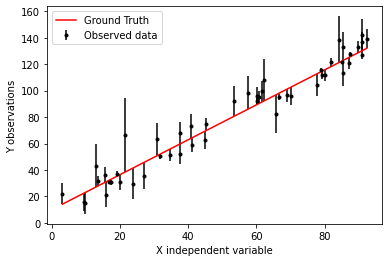

In [3]:
# true parameters
a = 10.0
b = 1.321

N = 50

x = np.sort(100*np.random.rand(N))
y = forward_model(x,a,b)

# Real world observations are noisy...
# we have random errors there, no systematic bias
ese = 10*np.random.randn(N)

y_observed = y + ese

plt.errorbar(x,y_observed,yerr=ese,fmt='.',color="k",label="Observed data")
plt.plot(x,y,"r-",label="Ground Truth")
plt.xlabel("X independent variable")
plt.ylabel("Y observations")
plt.legend()

# What we did...

Our forward problem is given by a first order polynomial function:

$d = a + b*x $ . eq. 2

An easy and well used way to fit our data with eq. 2 is to use **least-square regression**, i.e. use an algorithm to minimize the value of the **objective function**:

$misfit = \sum_{i=1}^{n}{\frac{(d_n-m_n)^2}{\sigma_n ^2}}$ , eq. 3

To do so, we did:

Obtained parameters:
[9.15524554 1.32946046]
Obtained errors:
[0.98013424 0.01391733]


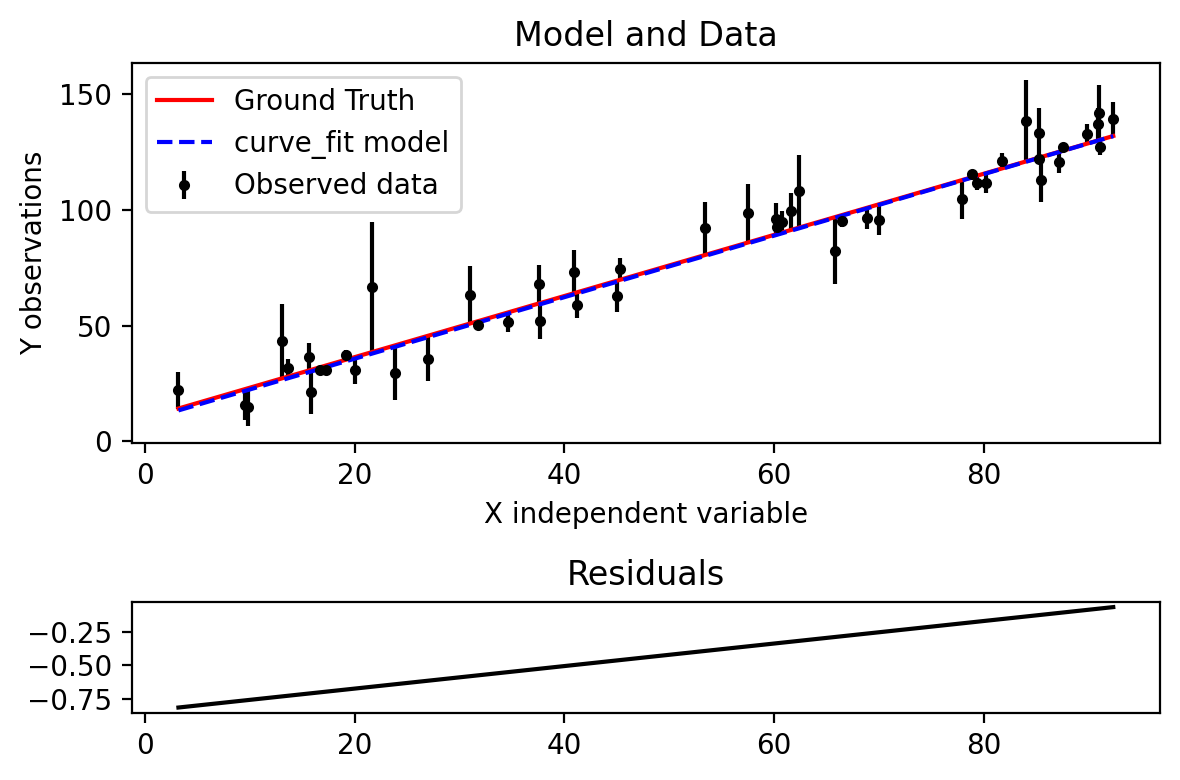

In [4]:
# we need to import curve_fit for fitting our curve
# we also import uncertainties for error propagation
from scipy.optimize import curve_fit 
import uncertainties

# then we fit and record the best parameters popt 
# and the covariance matrix pcov
popt, pcov = curve_fit(forward_model,x,y_observed,sigma=ese) 

print("Obtained parameters:")
print(popt)

# parameter errors are estimated from the square root of the diagonal of the covariance matrix
perr = np.sqrt(np.diag(pcov)) 
print("Obtained errors:")
print(perr)

# we calculate the best estimate
y_pred_curvefit = forward_model(x,*popt) # parameter unwrapping (*popt) works only in Python 3

plt.figure(dpi=200)

plt.subplot(3,1,(1,2))
plt.errorbar(x,y_observed,yerr=ese,fmt='.',color="k",label="Observed data")
plt.plot(x,y,"r-",label="Ground Truth")
plt.plot(x,y_pred_curvefit,"b--",label="curve_fit model")
plt.title("Model and Data")
plt.xlabel("X independent variable")
plt.ylabel("Y observations")
plt.legend()

plt.subplot(3,1,3)
plt.plot(x,(y_pred_curvefit - y),"k-")
plt.title("Residuals")

plt.tight_layout()

# Can we do better? Or in other terms: more about optimisation and inverse problems

The curve_fit() function is nice, but is only done for curve fitting. Moreover, error estimations are performed from the parameter covariance matrix pcov, and this may not be always optimal. Now, we are going to give a more general definition of the *optimisation* problem, which will allow us to fit complex models.

## The inverse problem

Eq. 1 provides us some observations *d* given a model *m*. This is called the **forward problem**.

Now, it turns out that we have observed *d*, guessed (or constructed from a theory) our model *m*, but have no idea of the parameters.

We can find those with inversion, i.e. solving the [**inverse problem**](https://en.wikipedia.org/wiki/Inverse_problem).

We did that with a common statistical least square approach in the previous cells. Now, we are going to switch from a statistical perspective to a Bayesian perspective. This will improve our vision of modelling, particularly regarding the error determination.

Adopting a Bayesian perspective, there is not a best model, but different models with associated probabilities, a.k.a likelyness. This implies that the most likely model may actually not be the good one, this is just the most likely model...

Another important point of a Bayesian perspective is that we assume some initial knowledge of the model parameters. Contrary to what is done in the curve_fit() function, we can use this knowledge to improve our ability to determine the parameters of the models, or, more precisely, their probability density function.


Typically, we define the probability of model $\mathbf{m}$ as the exponent of the negative misfit,
$$\begin{align}P(\mathbf{d} | \mathbf{m})& = k\cdot \exp\left\{-\frac{1}{2}\phi(\mathbf{d},\mathbf{m})\right\}\\&=k\cdot\exp\left\{ -\sum\frac{ (d_i - g_i(\mathbf{m}))^2}{2\sigma_i^2}\right\}\end{align}$$
where $k$ is a normalisation constant. You might recognise this formula - it is simply a multi-dimensional Gaussian.

We can now employ Bayes' theorem:

$$ P(\mathbf{m}|\mathbf{d}) = \frac{P(\mathbf{d}|\mathbf{m}) P(\mathbf{m})}{P(\mathbf{d})}$$

Here, $P(\mathbf{m})$ is the **prior distribution**, describing what we thought *before we saw the data*. $P(\mathbf{m}|\mathbf{d})$ is the **posterior distribution**, and describes our state of knowledge *after seeing the data*. $P(\mathbf{d})$ is the probability of data, so 1 actually in our case. $P(\mathbf{d}|\mathbf{m})$ is the **likelyhood function**, a term we already saw above.

What does a likelyhood looks like? Well, a Gaussian likelyhood looks like this :

Text(0.5, 1.0, 'Model likelyhood function')

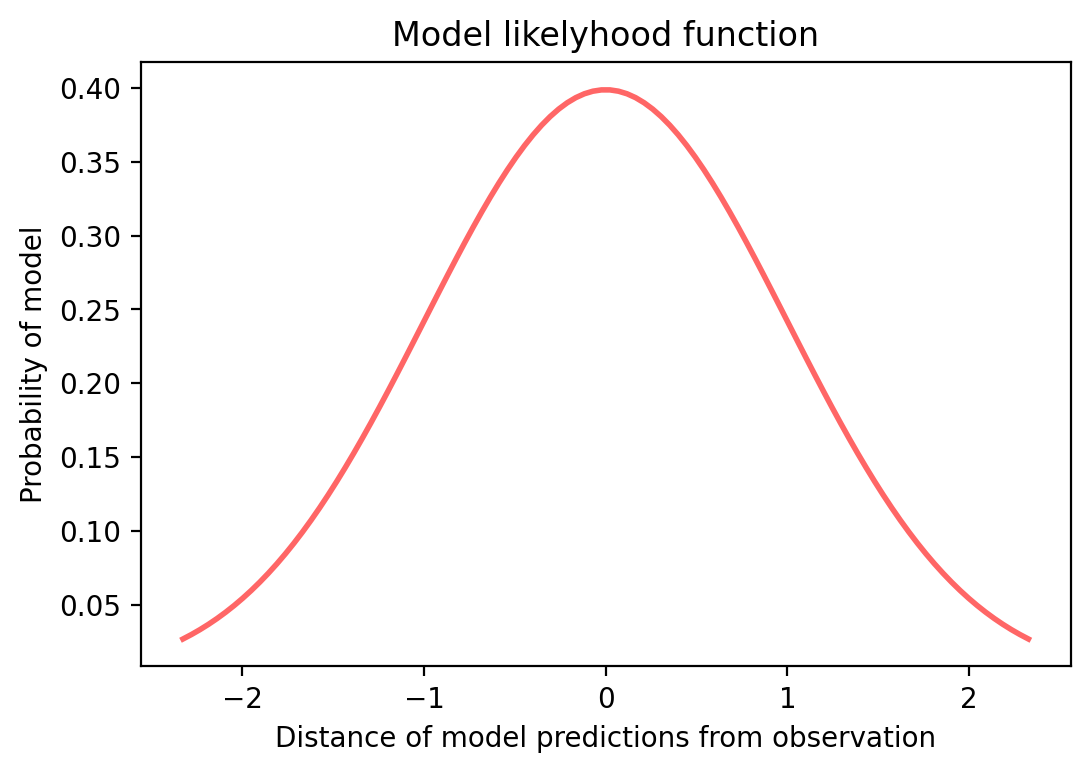

In [5]:
from scipy.stats import norm # this is a normal (gaussian) distribution of mean 0 and sigma 1

dm = np.linspace(norm.ppf(0.01),
                 norm.ppf(0.99), 100)
plt.figure(dpi=200)
plt.plot(dm, norm.pdf(dm),
        'r-', lw=2, alpha=0.6, label='norm pdf')

plt.xlabel("Distance of model predictions from observation")
plt.ylabel("Probability of model")
plt.title("Model likelyhood function")

According to Bayes' theorem, the probability of a model given a set of data includes *à prior* information *P*(**m**). In practice, we define a [**joint probability distribution**](https://en.wikipedia.org/wiki/Joint_probability_distribution) which will be equal to the sum of the likelyhood probability distribution of the model given the data times the *à prior* model probability distribution:

$$P(\mathbf{d} | \mathbf{m})=k\cdot\exp\left\{ -\sum\frac{ (d_i - g_i(\mathbf{m}))^2}{2\sigma_i^2}\right\}\cdot k\cdot\exp\left\{ -\sum\frac{ (m_n - m_{prior}))^2}{2\sigma_{m_{prior}}^2}\right\}$$

with *n* the number of model parameters. In practice, we will see two different forms of the last equation, one for a Gaussian probability and another one for a uniform probability. The graph below summarizes the idea for the *a* parameter.

The *a* parameter has a true value of 10.0. I could make a first-order estimate around 0 from the first figure, so assume 0 ± 20. We also assume a uniform distribution, because it is clear from the first plot that *a* cannot be lower than -20 or higher than 30, so we can say the model should present a uniform probability of 1 between -20 and 30, and a probability of 0 outside this range.

The following code allows generating a figure to compare the two different prior equations.

Text(0.5, 1.0, 'The prior probability functions for parameter a')

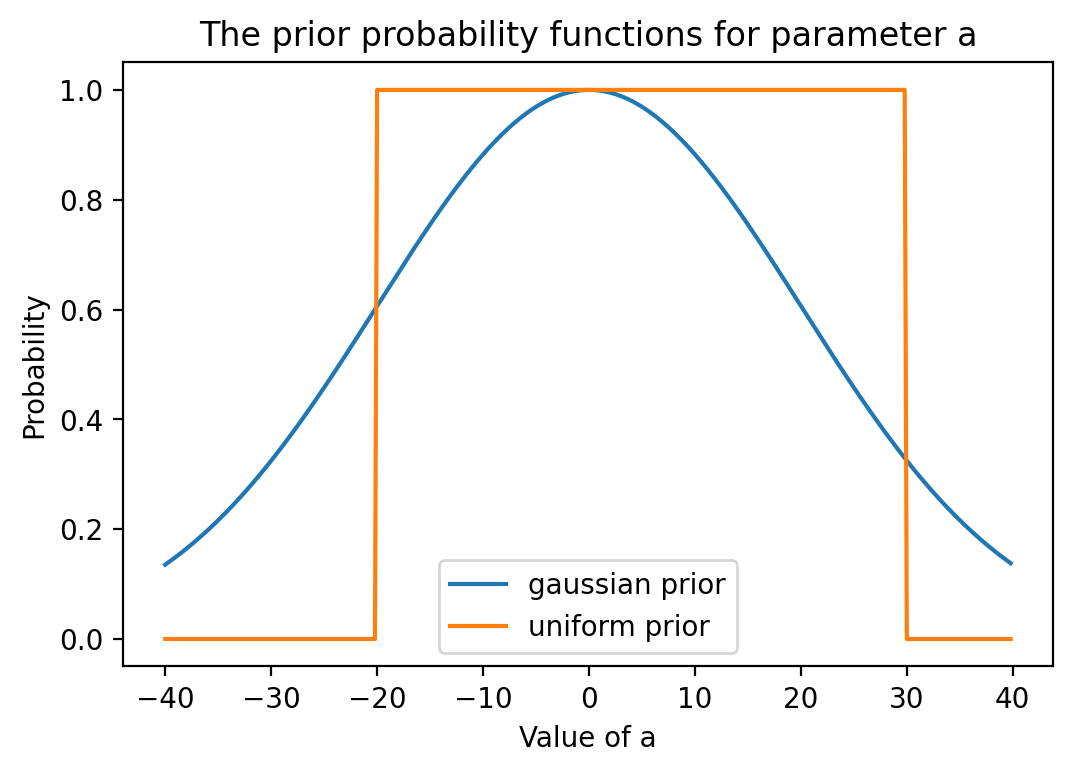

In [6]:
x_a = np.arange(-40,40,0.2)

# a dummy way to do a port function
uni = np.zeros(len(x_a))
uni[(x_a>-20)&(x_a<30)] = 1.0

# plotting things
plt.figure(dpi=200)
plt.plot(x_a,np.exp(-1/2*(x_a - 0.0)**2/(20.**2)),label="gaussian prior") 
plt.plot(x_a,uni,label="uniform prior")
plt.ylabel("Probability")
plt.xlabel("Value of a")
plt.legend()
plt.title("The prior probability functions for parameter a")

# Putting all those things in usable functions

Usually, the log of the probability distributions are used, as this avoids dealing with 0... We will do that below.

Our formula for the log likelyhood is now:

\begin{align} 
\ln P(y\,|\,x,\sigma,a,b) =
-\frac{1}{2} \sum_i \left[
  \frac{(d^i-g^{i}(a,b))^2}{\sigma_i^2}
  + \ln \left ( 2\pi\,\sigma_i^2 \right )
\right]
\end{align}

In [7]:
def lognormal(x,mu,std):
    var = std**2
    return -0.5*((x-mu)**2/var + np.log(2.0*np.pi*var))

def logprior(theta):
    """log prior probability function for the parameters
    
    This implementation uses a uniform distribution
    
    Parameters
    ==========
    theta : list
        the parameters
        
    Returns
    =======
    logprob_prior : the estimated probability of the prior values
    
    """
    a ,b = theta
    
    if -20 < a < 30 \
    and -10 < b < 10:
        return 0.0
    else:
        return -np.inf
    
def loglike(theta,x,y,yerr):
    """log likelyhood function
    
    This implementation uses the log of a gaussian distribution
    
    Parameters
    ==========
    theta : list
        the parameters
    x : ndarray
        the X variable
    y : ndarray
        the y observations
    yerr : ndarray
        the y errors
        
    Returns
    =======
    ln_likely : float
        the estimated likelyhood of the a model compared to observations
    
    """
    model = forward_model(x,*theta)
    ln_likely = np.sum(lognormal(y,model,yerr))
    return ln_likely

def logjoint(theta, x,y, yerr):
    """joint probability function
    
    This implementation uses the log of a gaussian distribution
    
    Parameters
    ==========
    theta : list
        the parameters
    x : ndarray
        the X variable
    y : ndarray
        the y observations
    yerr : ndarray
        the y errors
        
    Returns
    =======
    ln_prob : float
        the total likelyhood of a model compared to observations
    
    """
    lp = logprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglike(theta,x,y,yerr)

# First step: estimate the maximum of the distribution

Now we can find the maximum likelyhood of this distribution using the minimize() function from scipy.optimize

We first define our prior model as list containing our estimates of initial *a*, *b*, *c* values plus an estimate of the scaling of the likelyhood distribution.

In [8]:
theta_start = [0.,1.]

Let's check if this model is probable with the logprior function

In [9]:
if logprior(theta_start) == 0:
    print("Model viable")

Model viable


# Second step

OK, seems we can go. Now, we estimate the maximum likelyhood value with scipy.optimize.minimize

In [10]:
# Find the maximum likelihood value.
import scipy.optimize as op

chi2 = lambda *args: -2 * logjoint(*args)
result = op.minimize(chi2, theta_start, args=(x, y_observed,ese))
print(result)

      fun: 315.66184644405575
 hess_inv: array([[ 4.70115107e-01, -6.09663609e-03],
       [-6.09663609e-03,  9.47861375e-05]])
      jac: array([3.81469727e-06, 7.62939453e-06])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 3
     njev: 6
   status: 0
  success: True
        x: array([9.15524921, 1.3294604 ])


Obtained parameters:
[9.15524921]
Estimated bias
3.779003700095009
Fit RMSE is: 4069.8661090704645


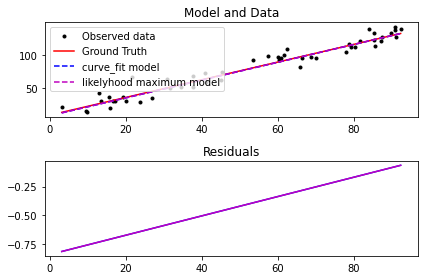

In [11]:
#Result is a dictionary, the best parameters are the x values.
popt_2 = result['x'][:]

print("Obtained parameters:")
print(result['x'][:-1])

print("Estimated bias")
print(np.exp(result['x'][-1]))

# we calculate the best estimate
y_pred_minimize = forward_model(x,*popt_2) # parameter unwrapping (*popt) works only in Python 3

print("Fit RMSE is: "+str(np.sum((y_pred_minimize-y_observed)**2)))

plt.figure()

plt.subplot(2,1,1)
plt.plot(x,y_observed,"k.",label="Observed data")
plt.plot(x,y,"r-",label="Ground Truth")
plt.plot(x,y_pred_curvefit,"b--",label="curve_fit model")
plt.plot(x,y_pred_minimize,"m--",label="likelyhood maximum model")
plt.title("Model and Data")
plt.legend()

plt.subplot(2,1,2)
plt.plot(x,(y_pred_curvefit - y),"b-")
plt.plot(x,(y_pred_minimize - y),"m-")
plt.title("Residuals")

plt.tight_layout()

OK, we get a similar result, which makes sense as we are virtually performing the same thing: least square on a simple problem. However, we did not sample our probability distribution. To do that, we have two ways: using an existing Python library, or building our own function.

We will do both, as the later will allow understanding the concept, and using an existing library will allow more flexibility and robustness.

We are going to do implement first a very simple [*markov-chain monte carlo*](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) algorithm, called the [Metropolis Hasting](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm. The concept of this algorithm is simple: 

- generate a new model from a perturbation of the old one
- look at its probability
- accept the new model if its probability is higher than that of the old
- if lower, still leave a chance to accept it with a probability of X %


In [15]:
def mcmc(x,y,yerr,theta_start,scales,nb_iter):
    """MCMC Metropolis Hasting function to fit simple data
    
    Parameters
    ==========
    x : ndarray
        the X variable
    y : ndarray
        the y observations
    yerr : ndarray
        the y errors
    theta_prior : list
        the estimates of model parameters
    scales : list
        scaling factor for perturbating the parameters
    nb_iter : int
        number of iterations to perform = number of sampled models
        
    Returns
    =======
    theta_record : ndarray, shape = (nb_iter,size(theta_prior))
        the estimates of model parameters
    logrecord : 1D array
        the log probabilities of the nb_iter models
    acceptance_rate : 1D array
        the acceptance rate for each parameter
        
    """
    logrecord = np.zeros(nb_iter)
    theta_record = np.zeros((nb_iter,len(theta_start)))
    
    # to calculated acceptance rate
    accepted = 0
    
    # the starting parameters and logrecord
    logrecord[0] = logjoint(theta_start,x,y,yerr)
    theta_record[0,:] = theta_start
    
    i = 1
    while i < nb_iter:
        
        # we perturbate parameters
        theta_0 = theta_record[i-1,:] + scales*np.random.randn(2)
        # we calculate the associated log prob
        logprob_theta0 = logjoint(theta_0,x,y,yerr)
        # and the ratio (subtraction as we are in log) with the old logprob
        alpha = logprob_theta0 - logrecord[i-1]
        
        if np.exp(alpha) > np.random.rand(): # if our probability is actually higher than the previous
            logrecord[i] = logprob_theta0
            theta_record[i,:] = theta_0
            accepted = accepted + 1
        else: # otherwise we stay at the same position
            logrecord[i] = logrecord[i-1]
            theta_record[i,:] = theta_record[i-1,:]
            
        i += 1 # incrementing i as well as the number of tested models
            
    # calculation of acceptance rates
    acceptance_rate = accepted/(nb_iter-1)
    
    # results are returned
    return theta_record, logrecord, acceptance_rate  

## Jump scales

Now the tricky part in this type of algorithm is to adjust the scaling parameters, which defines the size of the jumps your random walk is doing.

To adjust that, we can have a first look at how much we affect the parameters. It should be of a small fraction only, but not too small also...

Another thing: as mcmc calculations can be expensive, a good practice can be to start from the maximum of the log likelyhood determined through gradient descent...

In [16]:
theta_start = result['x'] 

scales = [1e-1,1e-2]
scales_test = scales*np.random.randn(2)
print("Parameters starting value: "+str(theta_start)) 
print("Perturbations: "+str(scales_test))


Parameters starting value: [9.15524921 1.3294604 ]
Perturbations: [-0.08818947 -0.00671322]


Seems not too bad, let's give it a go.

## Chains

To sample more efficiently the posterior, one usually uses several "chains". It allows to avoid running several "walks" of the MH algorithm in parallel for instance, and to sample faster the posterior.

In [17]:
nb_iter= 100000
nb_chains = 5

chains_theta = []
chains_logrecord = []
chains_acceptance = []

for i in range(nb_chains):
    theta_mcmc, logrecord_mcmc, acceptance_rate = mcmc(x,y,ese,theta_start,scales,nb_iter)
    chains_theta.append(theta_mcmc)
    chains_logrecord.append(logrecord_mcmc)
    chains_acceptance.append(acceptance_rate)
    


# Result analysis

The first thing to do with MCMC will be to check if we reach some sort of stability.

We do that by plotting the parameters as a function of the number of iterations.

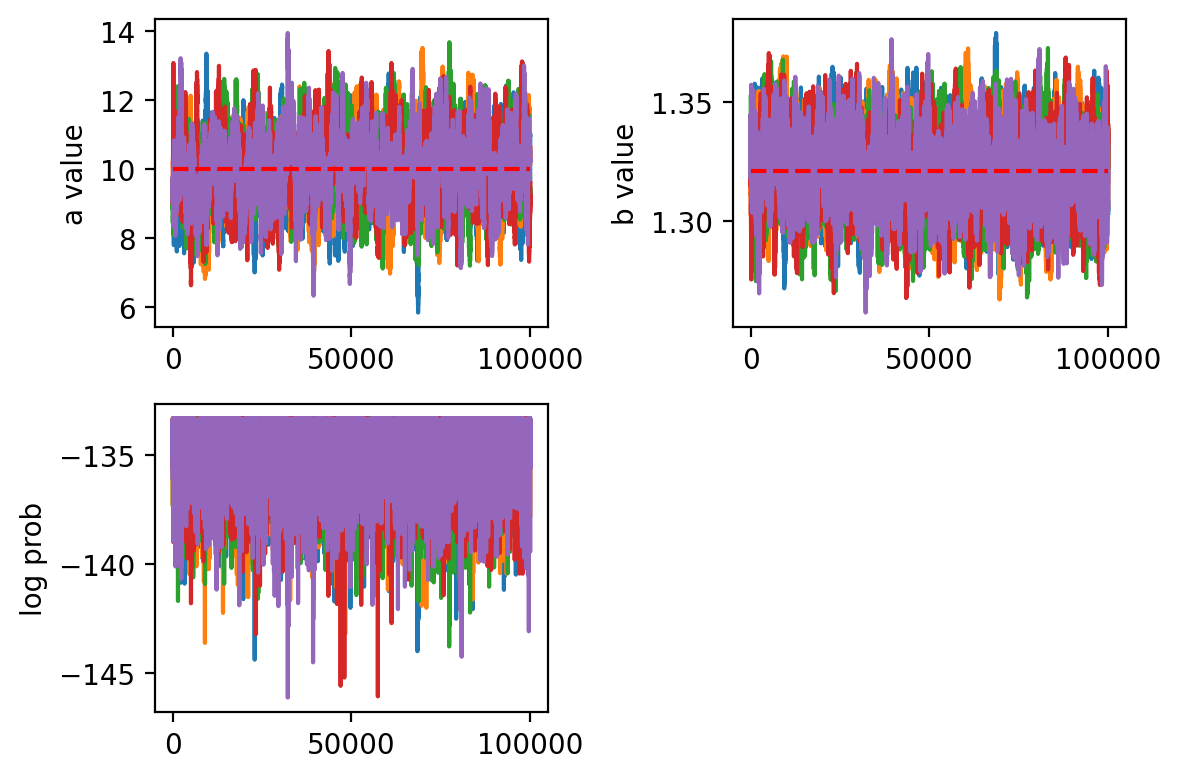

In [18]:
plt.figure(dpi=200)

plt.subplot(2,2,1)
for i in range(nb_chains):
    plt.plot(chains_theta[i][:,0])
plt.plot([0,nb_iter],[a,a],"r--")
plt.ylabel("a value")

plt.subplot(2,2,2)
for i in range(nb_chains):
    plt.plot(chains_theta[i][:,1])
plt.plot([0,nb_iter],[b,b],"r--")
plt.ylabel("b value")

plt.subplot(2,2,3)
for i in range(nb_chains):
    plt.plot(chains_logrecord[i])
plt.ylabel("log prob")


plt.tight_layout()

# Looking at the acceptance rates. They should be around 0.2 to 0.5, optimally at 0.3.

If they are not, tune the 'scales'.

In [19]:
print(chains_acceptance)

[0.5290752907529075, 0.5302853028530286, 0.5280252802528025, 0.5296652966529666, 0.5331553315533155]


## burn-in and thinning

Usually one does not keep all samples from the posterior because it will make a lot in long runs... One thus removes the first N samples assuming that convergence was only achieved after a certain number of iterations. Also, chains are thinned, i.e. only every M samples are kept.

In [20]:
Burnin = 20000
thin = 10

samples_MH=[]
for i in range(nb_chains):
    samples_MH.append(chains_theta[i][Burnin:thin:-1,:])
samples_MH = np.concatenate(samples_MH)

a_mcmc = np.median(samples_MH[:,0])
b_mcmc = np.median(samples_MH[:,1])
nb_drawn_samples = len(samples_MH)

# MCMC home-made algorithm histograms

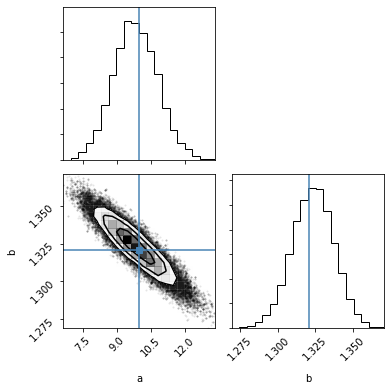

In [21]:
import corner
labels = ['a','b','c','lnf']
fig_mh = corner.corner(samples_MH,labels=labels,truths=[a, b])
plt.tight_layout()

Good! We defined good scaling values for the jumps, and the above histograms show that our algorithm efficiently sampled the posterior distribution.

Question : we could ask ourselves how the distribution of each parameter compares with that predicted by curve_fit for instance.

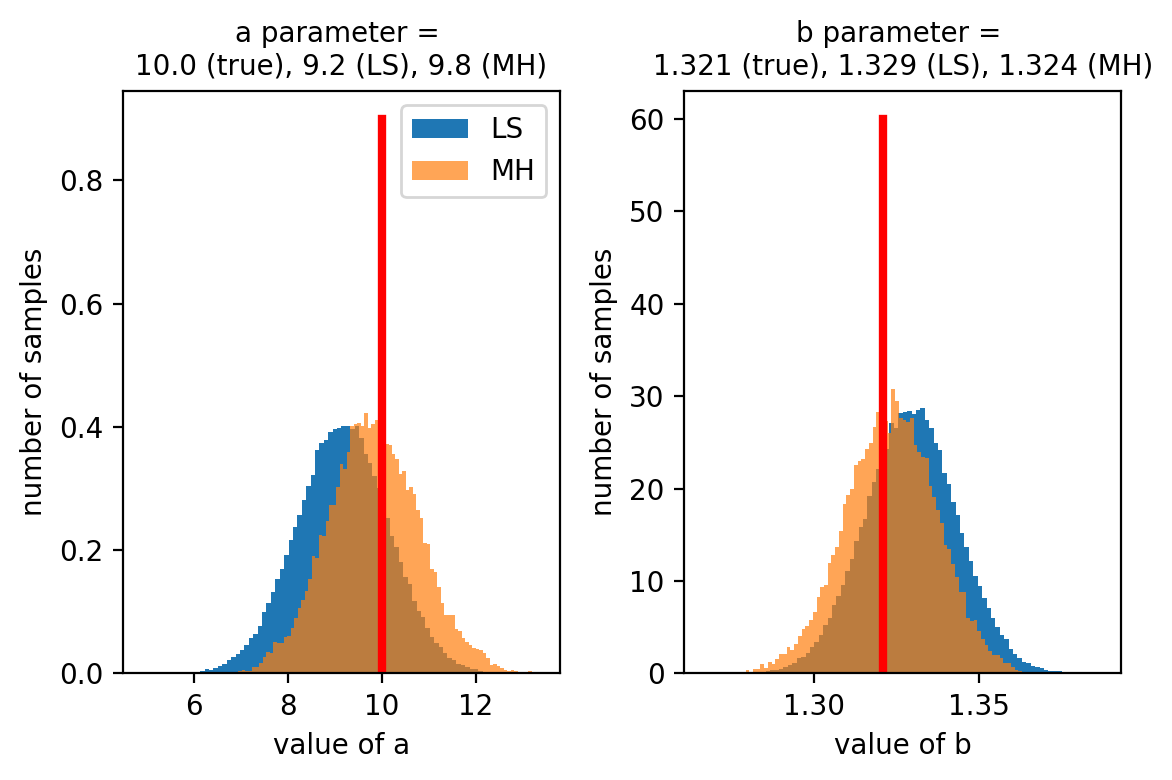

In [22]:
plt.figure(dpi=200)
plt.subplot(1,2,1)
plt.title("a parameter = \n{:.1f} (true), {:.1f} (LS), {:.1f} (MH)".format(a,popt[0],a_mcmc),fontsize=10)
plt.hist(np.random.normal(loc=popt[0],scale=perr[0],size = nb_drawn_samples),
         bins = 90,density=True,label="LS")
plt.hist(samples_MH[:,0],
                 alpha=0.7,bins=90,density=True,label="MH")
plt.plot([a,a],[0,0.9],"r-",linewidth=3)
plt.xlabel("value of a")
plt.ylabel("number of samples")
plt.legend(loc="best")

plt.subplot(1,2,2)
plt.title("b parameter = \n{:.3f} (true), {:.3f} (LS), {:.3f} (MH)".format(b,popt[1],b_mcmc),fontsize=10)
plt.hist(np.random.normal(loc=popt[1],scale=perr[1],size = nb_drawn_samples),
         bins = 90,density=True)
plt.hist(samples_MH[:,1],
                 alpha=0.7,bins=90,density=True)
plt.plot([b,b],[0,60],"r-",linewidth=3)
plt.xlabel("value of b")
plt.ylabel("number of samples")
plt.tight_layout()
plt.show()

# EMCEE

OK, we achieved nice results above, but in reality using the MH algorithm quickly becomes difficult for real world problems with many many variables. We will run into problems with the code, with the scaling parameters, and simply with the fact that MH is not the "best" (a.k.a. appropriate for your problem) MCMC method.

Again, as usual, people thought about that. There are great libraries to perform MCMC calculations. In Python, we can name [EMCEE](https://emcee.readthedocs.io/en/stable/) and [PyMC3](https://docs.pymc.io/).

For this course, as we can use directly the codes for likelyhood and prior written above in EMCEE, I will use EMCEE. But don't forget to check PyMC3, it works extremely well! Plus it uses an Hamiltonian MCMC algorithm that can also allows to deal with the fact that you d'ont know well your errors...

EMCEE is a python library providing access to the Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler. The explanation for what it does can be found in the paper [here](https://msp.org/camcos/2010/5-1/camcos-v5-n1-p04-p.pdf). 

Quickly, we will launch many samplers instead of a few chains, the movements of one sampler (a.k.a. walker in the following) being guided by those of the others. 

To use EMCEE, we thus record the dimension of the problem (the number of parameters) and set the number of walkers.

In [24]:
import emcee

# Set up the sampler.
ndim, nwalkers = len(theta_start), 100

# We also set the starting points of each walkers from the results of our LS fit, plus some perturbation.
pos = [result["x"] + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

# and we construct the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, logjoint, args=(x, y, ese))

## Run the sampler

So we're done with setup! Now we run the algorithm for 500 steps (in reality you probably want to run things for longer, we will see how we can check for convergence later).

In [25]:
# Clear and run the production chain.
sampler.run_mcmc(pos, 5000, progress=True)
print("Done.")

100%|██████████| 5000/5000 [00:12<00:00, 391.95it/s]

Done.


# Convergence

Nice results above. But how do we now we definitely sampled all the posterior? Usually, several criteria allow addressing this question, like the Gelman-Rubin criterion for instance.

For the Affine Invariante Ensemble sampler method, it seems that [the analysis fo the autocorrelation time is the best metric](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/#autocorr).

Again, I'm not going to repeat what is said on the website (see link above), so please read it carefully.

To check that we converged, we thus can do:

In [26]:
autocorr_times = sampler.get_autocorr_time()
    
print("Autocorrelation time for a is {:.0f}".format(autocorr_times[0]))
print("Autocorrelation time for b is {:.0f}".format(autocorr_times[1]))
print('')
print(' We thus need to get at least {:.0f} samples'.format(
    np.max(autocorr_times)*50)
     )

Autocorrelation time for a is 32
Autocorrelation time for b is 31

 We thus need to get at least 1585 samples


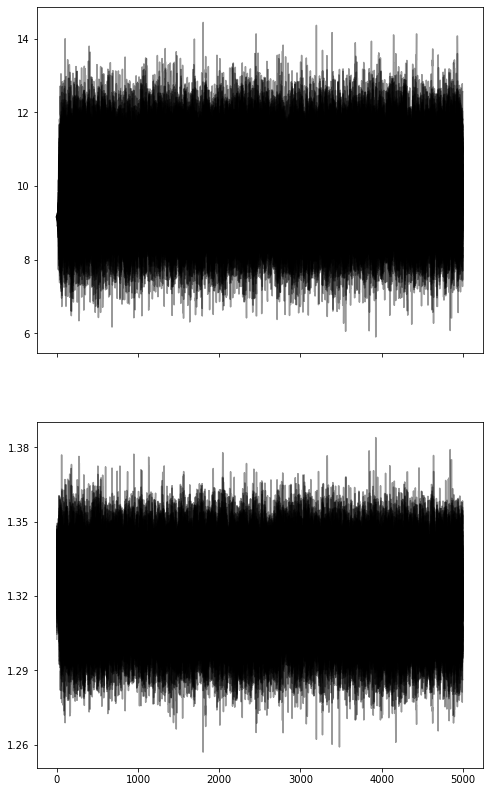

In [29]:
fig, axes = plt.subplots(len(theta_start), 1, sharex=True,figsize=(8,14))

for i in range(len(theta_start)):
    axes[i].plot(sampler.chain[:, :, i].T, color="k", alpha=0.4)
    axes[i].yaxis.set_major_locator(MaxNLocator(5))
    #axes[i].axhline(m_true, color="#888888", lw=2)
    #axes[i].set_ylabel("$m$")

# Burn-in and thinning

With the above analysis, we know that about 32 steps are needed for the chain to forget its starting point. 

We can throw away starting samples, like 2000, so we are sure we do not depend of the starting points.

Also, we can thin the chains, like grab every 50 samples, so we will also be sure that our final sample pool will contain "independent" samples.

In [30]:
# Make the triangle plot.
burnin = 2000
thinning = 50
samples = sampler.chain[:,burnin:thinning:-1, :].reshape((-1, ndim))
a_emcee = np.median(samples[:,0])
b_emcee = np.median(samples[:,1])

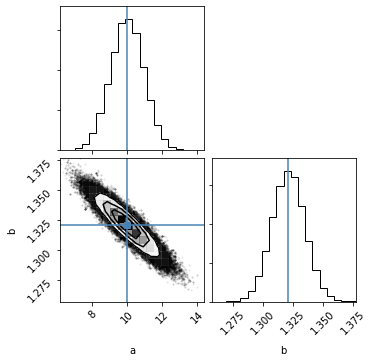

In [31]:
labels = ['a','b']
fig_emcee = corner.corner(samples,labels=labels,truths=[a, b])

## Comparison with previous methods

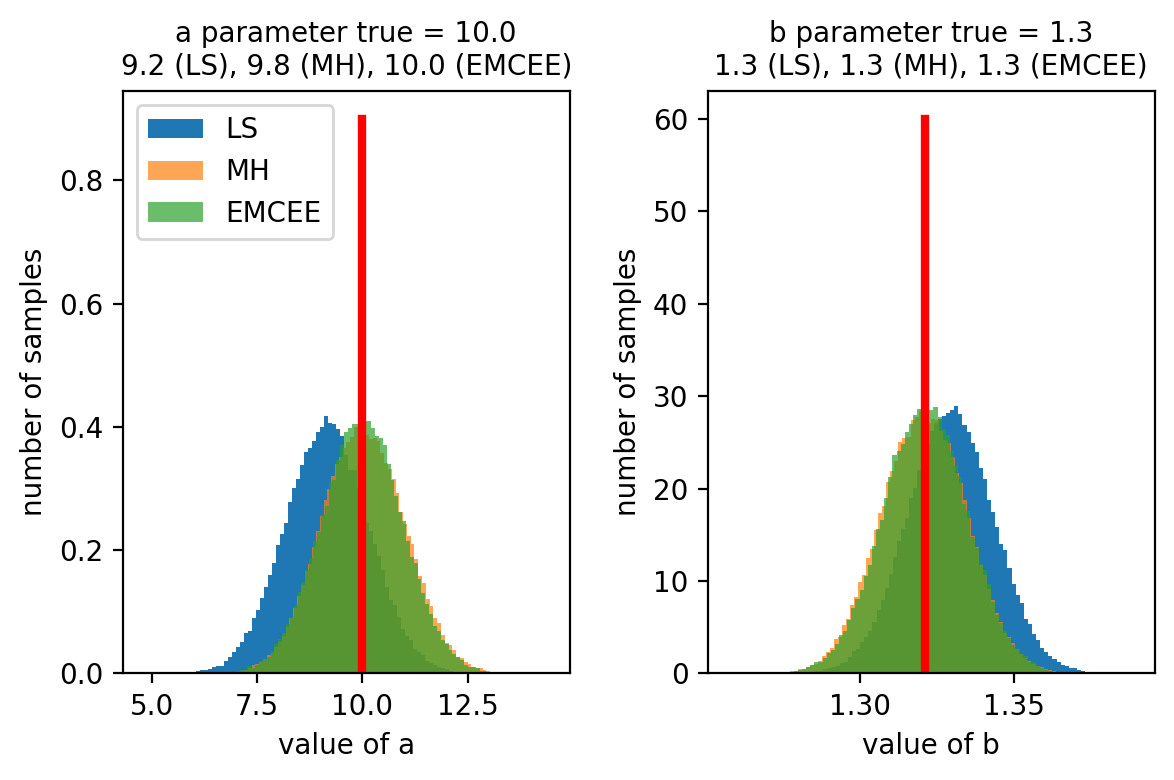

In [32]:
plt.figure(dpi=200)
plt.subplot(1,2,1)
plt.title("a parameter true = {:.1f}\n{:.1f} (LS), {:.1f} (MH), {:.1f} (EMCEE)".format(a,popt[0],a_mcmc,a_emcee),fontsize=10)
plt.hist(np.random.normal(loc=popt[0],scale=perr[0],size = nb_drawn_samples),
         bins = 90,density=True,label="LS")
plt.hist(np.concatenate(chains_theta)[:,0],
                 alpha=0.7,bins=90,density=True,label="MH")
plt.hist(samples[:,0],
                 alpha=0.7,bins=90,density=True,label="EMCEE")
plt.plot([a,a],[0,0.9],"r-",linewidth=3)
plt.xlabel("value of a")
plt.ylabel("number of samples")
plt.legend(loc="best")

plt.subplot(1,2,2)
plt.title("b parameter true = {:.1f}\n{:.1f} (LS), {:.1f} (MH), {:.1f} (EMCEE)".format(b,popt[1],b_mcmc,b_emcee),fontsize=10)
plt.hist(np.random.normal(loc=popt[1],scale=perr[1],size = nb_drawn_samples),
         bins = 90,density=True)
plt.hist(np.concatenate(chains_theta)[:,1],
                 alpha=0.7,bins=90,density=True)
plt.hist(samples[:,1],
                 alpha=0.7,bins=90,density=True,label="EMCEE")
plt.plot([b,b],[0,60],"r-",linewidth=3)
plt.xlabel("value of b")
plt.ylabel("number of samples")
plt.tight_layout()
plt.show()

# Plotting models and data

Now with MCMC methods, we do not get a "best" results. We can sample the posterior, and calculate our values from those samples.

It has an advantage : error propagaztion is done well, even if errors follow non-gaussian distributions (remember, the formulas for error propagation we saw assume that errors follow Gaussian (Normal) distributions...).

In [33]:
y_MH = []
y_EMCEE = []

for i in range(2000):
    j = np.random.randint(0,len(samples_MH))
    y_MH.append(forward_model(x,samples_MH[i,0],samples_MH[j,1]))
    j = np.random.randint(0,len(samples))
    y_EMCEE.append(forward_model(x,samples[j,0],samples[j,1]))
    
y_EMCEE = np.array(y_EMCEE).T
y_MH = np.array(y_MH).T

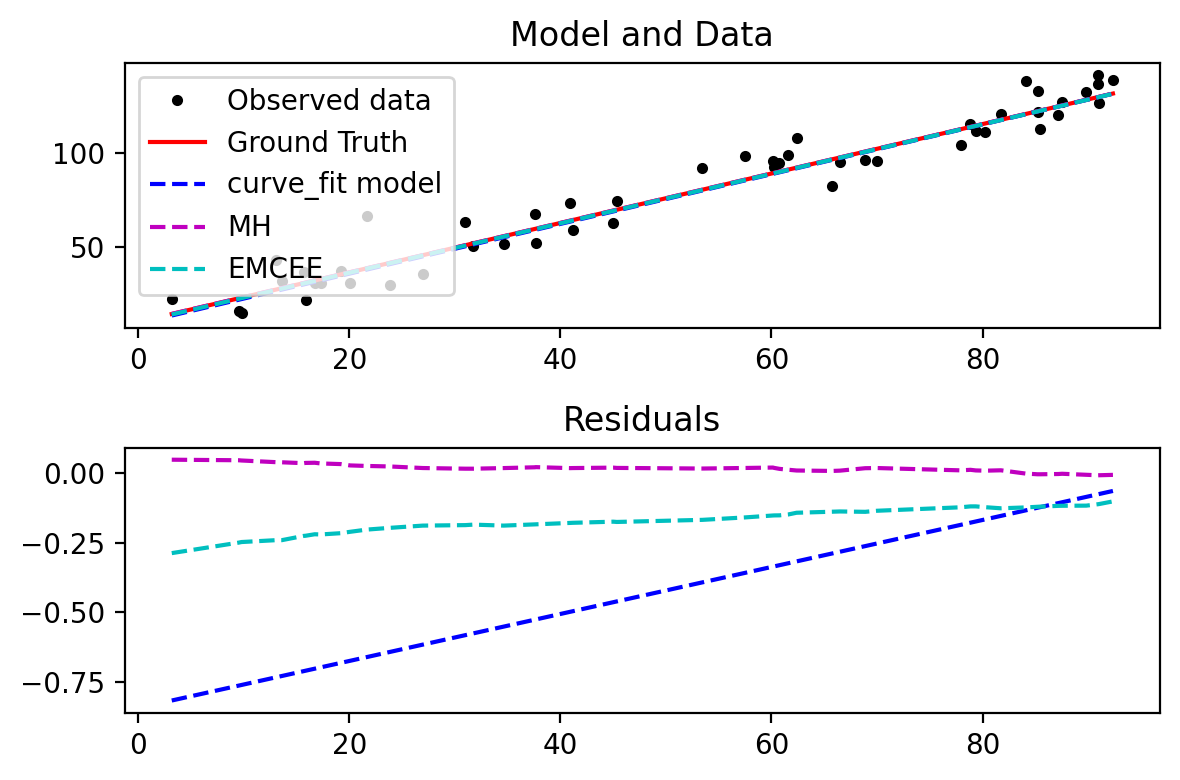

In [34]:
plt.figure(dpi=200)

plt.subplot(2,1,1)
plt.plot(x,y_observed,"k.",label="Observed data")
plt.plot(x,y,"r-",label="Ground Truth")
plt.plot(x,y_pred_curvefit,"b--",label="curve_fit model")
plt.plot(x,np.median(y_EMCEE,axis=1),"m--",label="MH")
plt.plot(x,np.median(y_MH,axis=1),"c--",label="EMCEE")
    
plt.title("Model and Data")
plt.legend()

plt.subplot(2,1,2)
plt.plot(x,(y_pred_curvefit - y),"b--")
plt.plot(x,(np.median(y_EMCEE,axis=1)- y),"m--")
plt.plot(x,(np.median(y_MH,axis=1)- y),"c--")
plt.title("Residuals")

plt.tight_layout()